# MLDA on dummy posteriors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.integrate import solve_ivp

import tinyDA as tda

In [2]:
def extract_parameters(list):
    output = []
    for element in list:
        output.append(element.parameters.tolist()[0])

    return(np.array(output))

### Set up the likelihoods

In [3]:
my_prior = stats.uniform(loc=-50, scale=100)

In [4]:
sigma = 1
# define the likelihood
s0, m0 = 4, 4
s1, m1 = 2, 2
s2, m2 = 1, 0

cov_likelihood_l0 = (s0*sigma)**2*np.eye(1)
cov_likelihood_l1 = (s1*sigma)**2*np.eye(1)
cov_likelihood_l2 = (s2*sigma)**2*np.eye(1)

my_loglike_l2 = tda.GaussianLogLike(np.eye(1)*m2, cov_likelihood_l2)
my_loglike_l1 = tda.AdaptiveGaussianLogLike(np.eye(1)*m1, cov_likelihood_l1)
my_loglike_l0 = tda.AdaptiveGaussianLogLike(np.eye(1)*m0, cov_likelihood_l0)

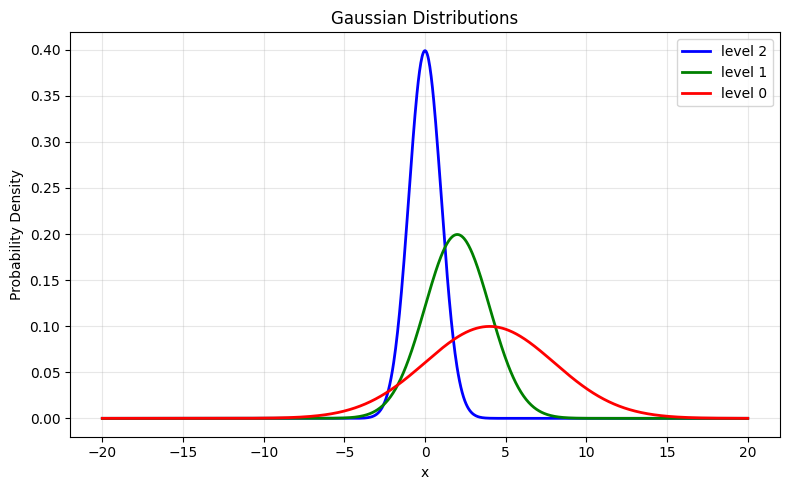

In [5]:
means = [m2, m1, m0]    # Means of the distributions
stds = [s2, s1, s0]  # Standard deviations
colors = ['blue', 'green', 'red']  # Colors for each plot
labels = ['level 2', 'level 1', 'level 0']

# Create x values
x = np.linspace(-20, 20, 1000)

# Plot each Gaussian
plt.figure(figsize=(8, 5))
for mean, std, color, label in zip(means, stds, colors, labels):
    y = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean)/std)**2)
    plt.plot(x, y, color=color, linewidth=2, label=label)

# Add labels and legend
plt.title('Gaussian Distributions')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
# define a model.
def my_model(parameter):
    return parameter

In [7]:
# set up the link factories
my_posterior_l2 = tda.Posterior(my_prior, my_loglike_l2, my_model)
my_posterior_l1 = tda.Posterior(my_prior, my_loglike_l1, my_model)
my_posterior_l0 = tda.Posterior(my_prior, my_loglike_l0, my_model)

my_posteriors = [my_posterior_l0, my_posterior_l1, my_posterior_l2]

In [8]:
# get the maximum a posteriori point.
MAP = tda.get_MAP(my_posterior_l2)

In [9]:
MAP

array([7.15384605e-08])

### Set up the proposal

In [10]:
# random walk Metropolis
rwmh_cov = np.eye(1)
rmwh_scaling = 0.1
rwmh_adaptive = True
my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

# Adaptive Metropolis
#am_cov = np.eye(true_parameters.size)
#am_t0 = 100
#am_sd = None
#am_epsilon = 1e-6
#am_adaptive = True
#my_proposal = tda.AdaptiveMetropolis(C0=am_cov, t0=am_t0, sd=am_sd, epsilon=am_epsilon)

#dream_m0 = 1000
#dream_delta = 1
#dream_Z_method = 'lhs'
#dream_adaptive = True
#my_proposal = tda.DREAMZ(M0=dream_m0, delta=dream_delta, Z_method=dream_Z_method, adaptive=dream_adaptive)

### Sample

In [11]:
import os
if "CI" in os.environ:
    iterations = 120
    burnin = 20
else:
    iterations = 2500
    burnin = 500

In [12]:
# initialise the chain
my_chain = tda.sample(my_posteriors, my_proposal, iterations=1000, n_chains=2, initial_parameters=MAP, subchain_length=10, randomize_subchain_length=True)#, adaptive_error_model='state-independent')

Sampling 2 chains in parallel


2025-07-03 13:46:34,161	INFO worker.py:1786 -- Started a local Ray instance.


(raylet) [2025-07-03 22:05:34,796 E 105308 105308] (raylet) node_manager.cc:3065: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: d9d37902c4270e8565c8b7e4693286674e9a7e1d35d28138a1719b39, IP: 141.52.232.199) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 141.52.232.199`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) 
(raylet) [2025-07-04 10:58:35,808 E 105308 105308] (raylet) node_manager.cc:3065: 1 Workers (tasks / 

In [13]:
burnin=100

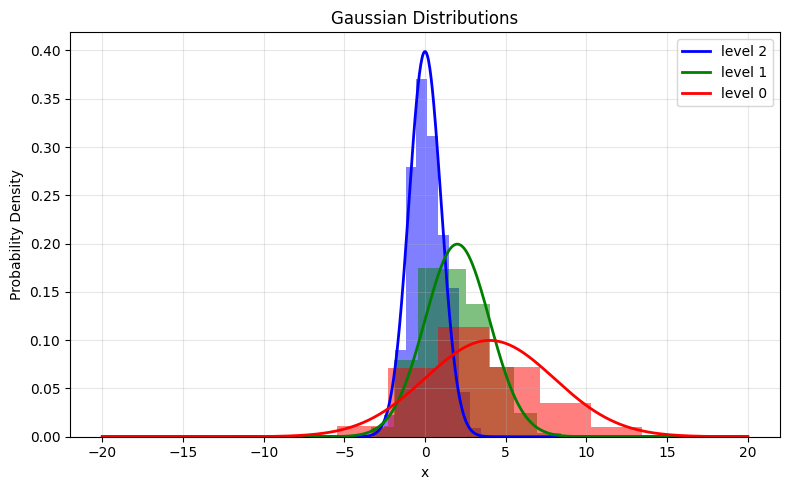

In [14]:
means = [m2, m1, m0]    # Means of the distributions
stds = [s2, s1, s0]  # Standard deviations
colors = ['blue', 'green', 'red']  # Colors for each plot
labels = ['level 2', 'level 1', 'level 0']

# Create x values
x = np.linspace(-20, 20, 1000)

# Plot each Gaussian
plt.figure(figsize=(8, 5))
for mean, std, color, label in zip(means, stds, colors, labels):
    y = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean)/std)**2)
    plt.plot(x, y, color=color, linewidth=2, label=label)

# Add labels and legend
plt.title('Gaussian Distributions')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
#plt.show()

plt.hist(extract_parameters(my_chain['chain_l2_0']), density=True, alpha=0.5, color="blue")
plt.hist(extract_parameters(my_chain['chain_l1_0']), density=True, alpha=0.5, color="green")
plt.hist(extract_parameters(my_chain['chain_l0_0']), density=True, alpha=0.5, color="red")

plt.show()

In [15]:
top = extract_parameters(my_chain['chain_l2_0'][burnin+1:])-extract_parameters(my_chain['promoted_l1_0'][burnin:])
middle = extract_parameters(my_chain['chain_l1_0'])[10*burnin:]-extract_parameters(my_chain['promoted_l0_0'])[10*burnin:]

In [16]:
np.mean(extract_parameters(my_chain['chain_l2_0'])[burnin:])

0.09961845929609749

In [17]:
np.mean(middle)+np.mean(top)

-2.902169664006381

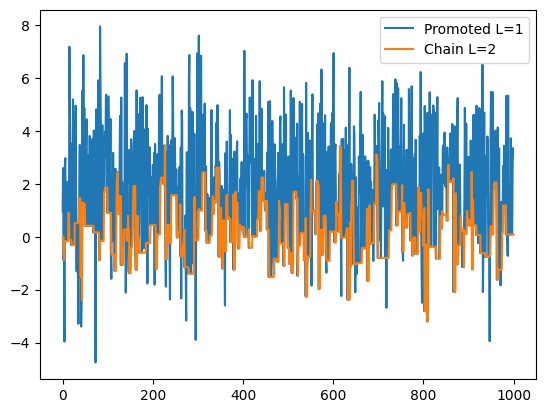

In [18]:
plt.plot(extract_parameters(my_chain['promoted_l1_0']), label='Promoted L=1')
plt.plot(extract_parameters(my_chain['chain_l2_0']), label='Chain L=2')
plt.legend()
#plt.plot(extract_parameters(my_chain['promoted_l0_0'])[::10])

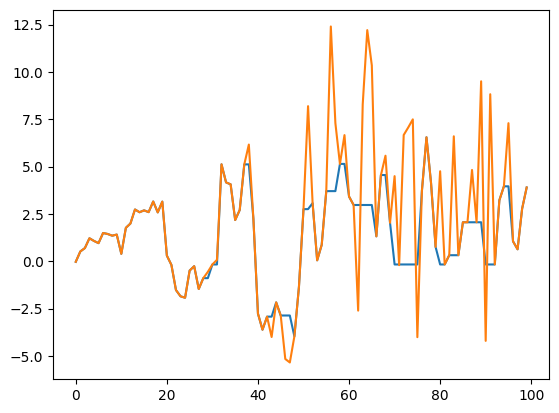

In [19]:
plt.plot(extract_parameters(my_chain['chain_l1_0'])[:100])
plt.plot(extract_parameters(my_chain['promoted_l0_0'])[:100])


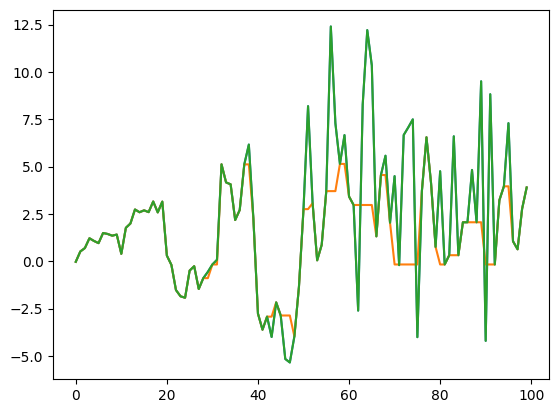

In [27]:
plt.plot(extract_parameters(my_chain['promoted_l0_0'])[0:100])
plt.plot(extract_parameters(my_chain['chain_l1_0'])[0:100])
plt.plot(tda.get_multilevel_inference_data(my_chain, attribute="parameters", burnin=0)['promoted']['l0_c0'][:100])

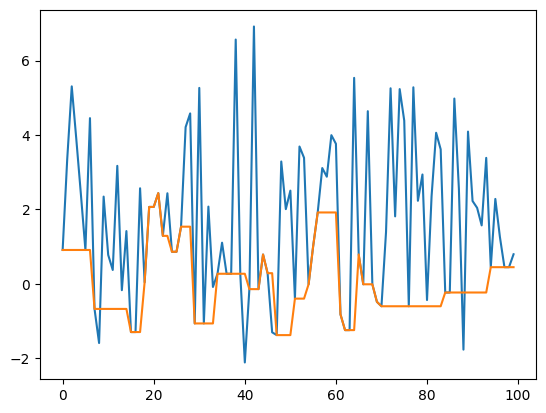

: 

In [ ]:
plt.plot(tda.get_multilevel_inference_data(my_chain, attribute="parameters", burnin=100)['promoted']['l1_c0'][:100])
plt.plot(tda.get_multilevel_inference_data(my_chain, attribute="parameters", burnin=100)['chains']['l2_c0'][:100])

In [22]:
levels = my_chain["levels"]
n_chains = my_chain["n_chains"]

In [29]:
tda.get_multilevel_inference_data(my_chain, attribute="parameters", burnin=100).keys()

dict_keys(['sampler', 'levels', 'n_chains', 'attribute', 'burnin', 'level_burnins', 'chains', 'promoted', 'dimension'])

In [25]:
tda.get_multilevel_inference_data(my_chain, attribute="parameters", burnin=100)['promoted'].keys()

dict_keys(['l0_c0', 'l0_c1', 'l1_c0', 'l1_c1'])

In [26]:
len(tda.get_multilevel_inference_data(my_chain, attribute="parameters", burnin=100)['promoted']['l0_c0'])

9000

In [32]:
est = np.mean(extract_parameters(my_chain['chain_l0_0'])[100*burnin:])+np.mean(middle)+np.mean(top)

In [33]:
print('Multilevel')
print(est)
print('Just top level')
print(np.mean(extract_parameters(my_chain['chain_l2_0'])[burnin:]))

Multilevel
0.33394840740587606
Just top level
0.32801156945592025


In [115]:
my_chain['promoted_l0_0'][0].parameters

array([1.32272854e-06])

In [116]:
my_chain['chain_l0_0'][0].parameters

array([-0.06191687])

In [117]:
my_chain['chain_l2_0'][7].parameters

array([1.4155147])

In [118]:
my_chain['chain_l2_0'][3].posterior

array([-5.60701112])

In [27]:
np.unique()

TypeError: unique() missing 1 required positional argument: 'ar'

In [119]:
accepted = []
last = my_chain['chain_l2_0'][0].posterior
for link in my_chain['chain_l2_0']:
    next = link.posterior
    accepted.append(last-next!=0)
    last = next

In [120]:
np.sum(accepted)

31

In [121]:
len(my_chain['promoted_l0_0'])

1001

In [122]:
def extract_parameters(list):
    output = []
    for element in list:
        output.append(element.parameters.tolist()[0])

    return(np.array(output))

In [32]:
i=1
for sample in my_chain['promoted_l0_0']:
    print(i)
    print(extract_parameters(my_chain['chain_l1_0'])[i])
    #print(extract_parameters(my_chain['chain_l1_0'])[10*i+sample])
    i+=1

1
0.16756471009311363
2
0.15089928378049572
3
0.10509217724777888
4
-0.37230763587610755
5
-0.30987149058792185
6
-0.21156720817366526
7
-0.22321568382046805
8
0.009042627297885533
9
-0.6536336871064208
10
0.22357029565283165
11
0.4538103852739351
12
0.8454271937715993
13
0.9380391491016292
14
1.4722991731623767
15
1.223193618625955
16
0.9687119120031931
17
2.064274304979355
18
2.2450053111639225
19
2.4573372182351045
20
-0.34395352694430636
21
-0.03733444481735189
22
-0.9815927682979708
23
0.47601901145621345
24
-0.5830383721711982
25
-0.9712025664639437
26
-0.9712025664639437
27
-1.7204337991407892
28
-0.9421899535716309
29
-1.341258476694632
30
-1.4997406241044524
31
-1.4997406241044524
32
-1.2738851888018936
33
-1.077586285144185
34
-1.077586285144185
35
-1.3007406827371852
36
-0.4165718005354686
37
1.9574865969184185
38
1.5081456397982413
39
0.6952856980178768
40
-1.077586285144185
41
-1.077586285144185
42
-1.077586285144185
43
-1.5796005617169313
44
-0.9151951564527155
45
-1.4215

IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [33]:
extract_parameters(my_chain['chain_l2_0'])

array([ 3.45878269e-06, -3.09871491e-01, -3.09871491e-01, -1.34125848e+00,
       -1.07758629e+00, -1.07758629e+00, -1.07758629e+00, -1.07758629e+00,
        1.59085927e-01,  7.71636195e-01,  7.71636195e-01, -1.24726401e+00,
       -1.24726401e+00, -1.24726401e+00, -1.24726401e+00, -1.24726401e+00,
       -1.24726401e+00, -1.24726401e+00, -1.24726401e+00, -1.24726401e+00,
       -1.24726401e+00, -1.24726401e+00, -1.24726401e+00, -1.24726401e+00,
       -2.46108709e-01, -2.46108709e-01, -2.46108709e-01, -2.46108709e-01,
       -2.46108709e-01, -2.46108709e-01, -2.46108709e-01,  9.08059206e-01,
        9.08059206e-01,  9.08059206e-01,  1.08636740e+00,  1.08636740e+00,
        1.08636740e+00,  1.08636740e+00,  8.26269683e-02, -3.43966893e-01,
       -3.43966893e-01, -3.43966893e-01, -3.43966893e-01, -3.43966893e-01,
        1.37218164e+00,  1.37218164e+00,  1.37218164e+00,  9.96504559e-01,
        9.96504559e-01,  9.96504559e-01,  8.00565606e-02,  8.00565606e-02,
        9.99704405e-01,  

In [34]:
len(np.unique(extract_parameters(my_chain['promoted_l0_0'])[:,0]))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [35]:
def _get_random_proposal_index(subchain_length):
    random_proposal_index = np.random.randint(1-subchain_length, -1)
    return random_proposal_index

In [36]:
maxi = -1
for i in range(300):
    k = _get_random_proposal_index(40)
    maxi = min(maxi, k)

print(maxi)

-39


In [37]:
my_chain.keys()

dict_keys(['sampler', 'n_chains', 'iterations', 'levels', 'subchain_lengths', 'randomize_subchain_length', 'chain_l2_0', 'chain_l1_0', 'promoted_l1_0', 'chain_l0_0', 'promoted_l0_0'])

In [73]:
chains = []

In [74]:
chains.append(tda.MLDAChain(my_posteriors, my_proposal, initial_parameters=MAP, subchain_lengths = [10,10], randomize_subchain_length=True))

In [75]:
chains[0].sample(100)

Running chain, α = 0.41: 100%|██████████| 100/100 [00:00<00:00, 110.44it/s]


In [80]:
chains[0].level

2

In [87]:
print(dir(chains[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'accepted', 'adaptive_error_model', 'chain', 'initial_parameters', 'level', 'posterior', 'proposal', 'randomize_subchain_length', 'sample', 'store_coarse_chain', 'subchain_length']


In [93]:
len(chains[0].proposal.proposal.promoted)

1001

In [94]:
sum_accepted = []
for i in range(10):
    for j in range(40):
        sum_accepted.append(sum(chains[0].proposal.proposal.accepted[i*j:i*j+40]))

In [95]:
np.sum(np.array(sum_accepted)==0)

88

In [96]:
chains[0].proposal.proposal.accepted

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False

In [124]:
tda.sampler._get_result_mlda(chains, 3, 120, 40, True, True).keys()

dict_keys(['sampler', 'n_chains', 'iterations', 'levels', 'subchain_lengths', 'randomize_subchain_length', 'chain_l2_0', 'chain_l2_1', 'chain_l1_0', 'chain_l1_1', 'promoted_l1_0', 'promoted_l1_1', 'chain_l0_0', 'chain_l0_1', 'promoted_l0_0', 'promoted_l0_1'])

In [44]:
test = []

test.append(test[-1])

test

IndexError: list index out of range

In [104]:
for i in reversed(range(2)):
    print(i)

1
0


### Diagnostics

In [126]:
idata = tda.to_inference_data(my_chain, level=2, burnin=burnin)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [124]:
import arviz as az

In [125]:
az.summary(idata)

NameError: name 'idata' is not defined

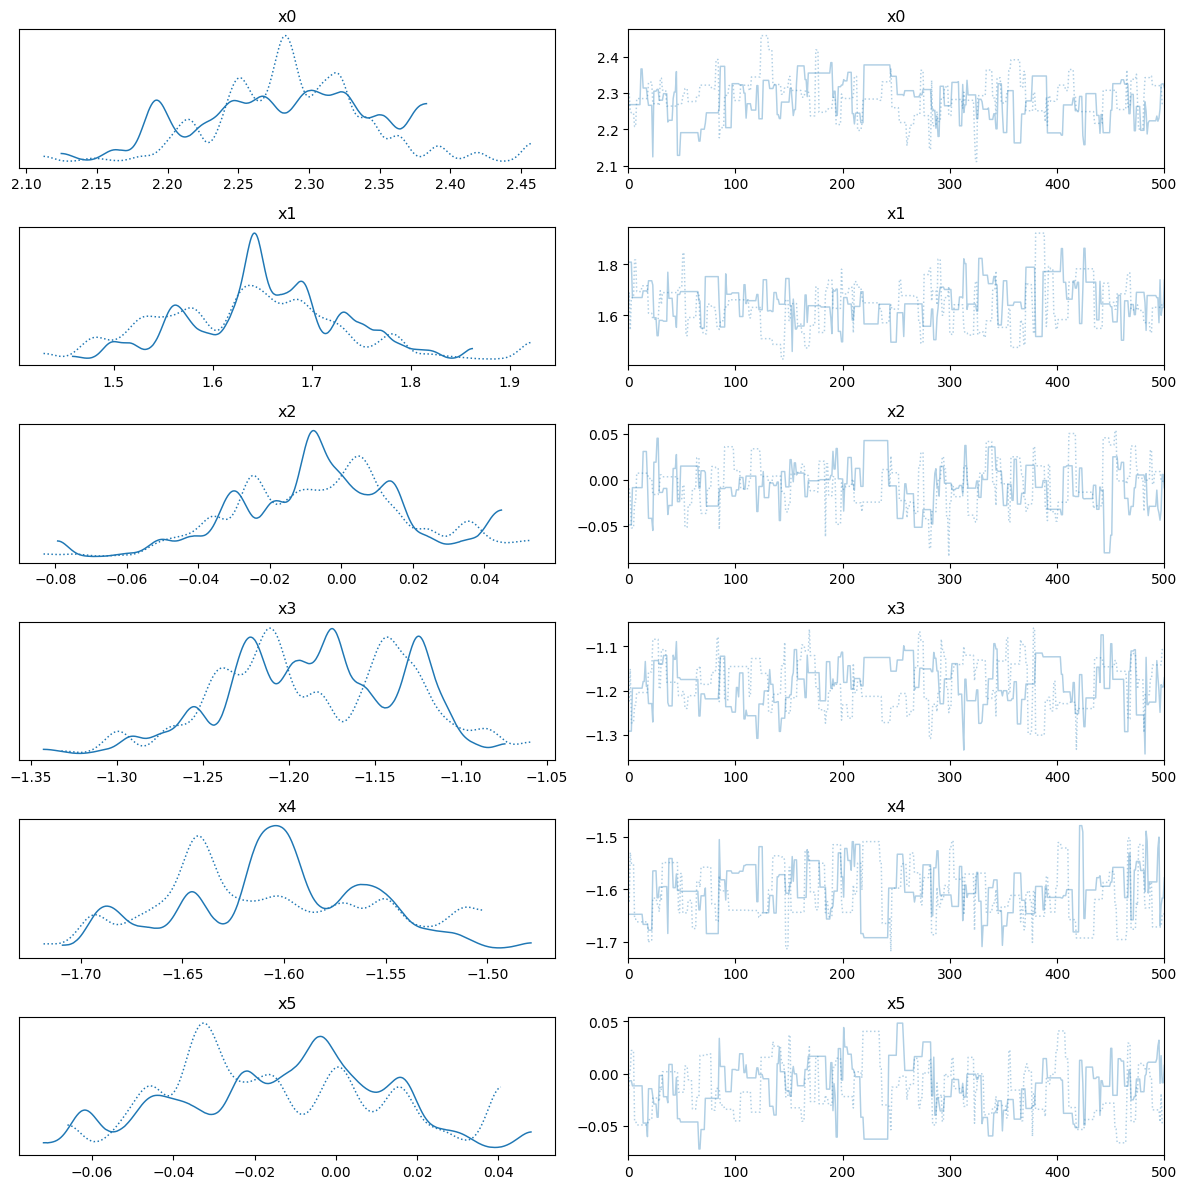

In [96]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()